# Objectif

Une entreprise de retail en ligne souhaite améliorer ses actions marketing en segmentant ses clients en fonction de leurs comportements d'achat. L'analyse s'appuie sur le dataset Online Retail contenant des transactions de clients britanniques entre 2010 et 2011. Les résultats permettront de développer des stratégies personnalisées, telles que des promotions ciblées ou des programmes de fidélisation.  
[Lien vers la BDD](https://archive.ics.uci.edu/dataset/352/online+retail)


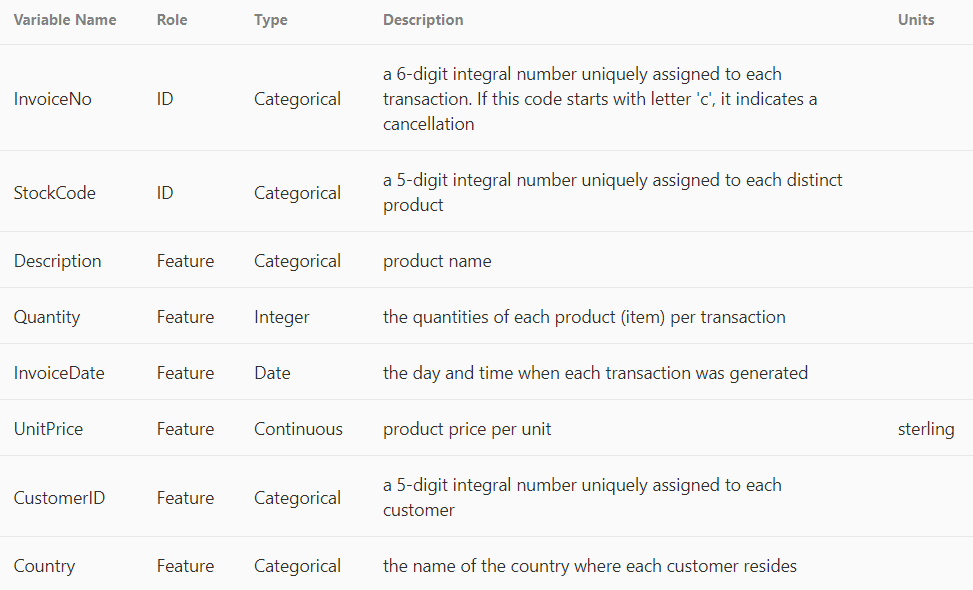



Phase 4 : Réduction des dimensions, si nécessaire

Phase 5 : Application des techniques d’apprentissage non supervisé

Phase 6 : Interprétation des segments obtenus et proposer des actions marketing adaptées.

Phase 7 : Export du modèle

# Phase 1 : Exploration des données

## Récupération des données

In [67]:
import pandas as pd

fichier_excel = 'Online Retail.xlsx'
data = pd.read_excel(fichier_excel)

data.shape

(541909, 8)

## Exploration des données

In [68]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [69]:
data.describe(include="all")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,NaN,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,NaN,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,NaN
min,NaN,NaN,NaN,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,NaN


**Conclusion** : On remarque que le jeu de données est assez conséquent, avec plus de 500 000 lignes. Il semble également y avoir plusieurs valeurs aberrantes, comme des quantités et des prix négatifs.

# Phase 2 : Prétraitement des données


## Gestion des valeurs nulles

In [70]:
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [71]:
data_cleaned=data.copy() #On crée une copie de data pour y retourner facilement en cas de souci, sans tout relancer
data_cleaned.dropna(inplace=True)

## Gestion des doublons

In [72]:
data_cleaned.duplicated().sum()

5225

In [73]:
data_cleaned.drop_duplicates(inplace=True)
data_cleaned.shape

(401604, 8)

## Gestion des valeurs aberrantes

In [74]:
colonnes = ['Quantity', 'UnitPrice']

for colonne in colonnes :
  q1_inc = data_cleaned[colonne].quantile(0.25)
  q3_inc = data_cleaned[colonne].quantile(0.75)
  iqr_inc = q3_inc - q1_inc
  borne_inf_inc = q1_inc - 1.5 * iqr_inc
  borne_sup_inc = q3_inc + 1.5 * iqr_inc
  data_cleaned = data_cleaned[(data_cleaned[colonne] >= borne_inf_inc) & (data_cleaned[colonne] <= borne_sup_inc)]

<Axes: >

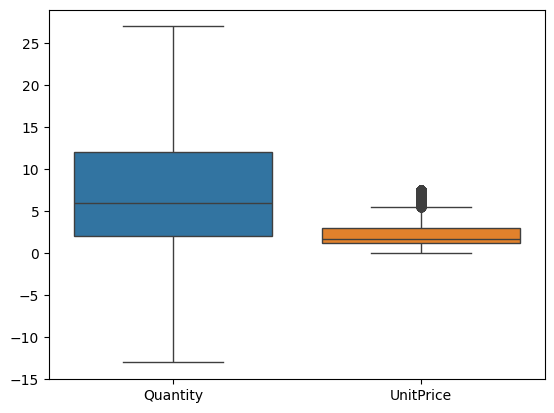

In [75]:
import seaborn as sns

sns.boxplot(data_cleaned[colonnes])

In [76]:
data_cleaned.shape

(339453, 8)

## Traitement des commandes annulées

Certaines commandes ont été annulées. Si on veut être précis sur les ventes réalisées et avoir une vision véritable de ce qui a été vendu, il est pertinent de supprimer ces ventes annulées.  
Dans le descriptif des données, on peut lire que les commandes annulées sont repérables grâce à une valeur de InvoiceNo qui commence par la lettre 'c'.  

In [77]:
data_annul = data_cleaned.copy()

data_annul['InvoiceNo'] = data_annul['InvoiceNo'].astype(str, errors='ignore')
data_annul = data_annul[data_annul['InvoiceNo'].str.startswith('C')]

data_annul.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom


On remarque que toutes les commandes annulées ont une quantité de produit négative. On peut vérifier si on obtient la même matrice en utilisant uniquement le critère Quantity<0 :

In [78]:
data_neg=data_cleaned.copy()
data_neg=data_neg[data_neg['Quantity']<0]
print(data_neg.shape)
data_neg.head()

(6188, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom


In [79]:
data_test=data_cleaned.copy()
data_test=data_test[data_test['InvoiceNo'].isin(data_annul['InvoiceNo'])]
data_test.shape

(6188, 8)

On cherche les données pour lesquelles la commande annulée correspond à la commande passée.

In [80]:
# Créez une nouvelle colonne avec les valeurs modifiées pour inclure uniquement les valeurs qui finissent par un nombre
data_test=data_cleaned.copy()
data_test['Commandes effectives'] = data_test['InvoiceNo'].apply(lambda x: x if str(x).endswith(str(536506)) else None)

# Filtrer le DataFrame pour ne conserver que les lignes où la nouvelle colonne n'est pas None
filtered_df = data_test.dropna(subset=['Commandes effectives'])

# Afficher le résultat
print(filtered_df['Commandes effectives'].unique())

['C536506']


On obtient bien le même résultat. A partir de là, on peut essayer de retrouver les commandes correspondantes pour chaque ligne.

In [81]:
print(data_cleaned[data_cleaned['InvoiceNo']==float(536391)])

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []


In [82]:
print(data_cleaned.loc[154])
print(data_cleaned.loc[155])

InvoiceNo                              C536383
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
Quantity                                    -1
InvoiceDate                2010-12-01 09:49:00
UnitPrice                                 4.65
CustomerID                             15311.0
Country                         United Kingdom
Name: 154, dtype: object
InvoiceNo                                 536384
StockCode                                  82484
Description    WOOD BLACK BOARD ANT WHITE FINISH
Quantity                                       3
InvoiceDate                  2010-12-01 09:53:00
UnitPrice                                   6.45
CustomerID                               18074.0
Country                           United Kingdom
Name: 155, dtype: object


Enlever toutes les données de quantités négatives.

In [83]:
data_cleaned=data_cleaned[data_cleaned['Quantity']>0]
print(data_cleaned.shape)
data_cleaned.head()

(333265, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Traitement des valeurs qualitatives

In [84]:
colonnes_qualitatives = ['InvoiceNo', 'StockCode', 'Description', 'Country']

for colonne in colonnes_qualitatives :
  data_cleaned[colonne] = data_cleaned[colonne].astype('category')

<ipython-input-84-490c8c982b39>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-84-490c8c982b39>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-84-490c8c982b39>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-84-490c8c9

## Pairplot

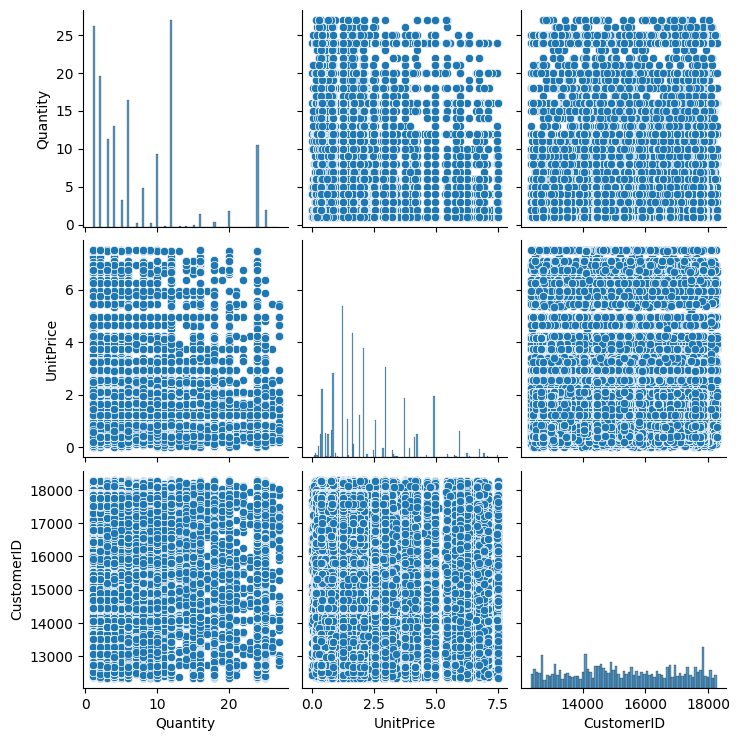

In [85]:
sns.pairplot(data_cleaned)

# Phase 3 : Feature Engineering
L'objectif de cette phase est de créer des variables pour la segmentation :
* Frequency
* Recency
* Monetary  

Pour cela, la première étape va être de grouper toutes les données par ID client, avant de calculer la date de dernière commande (recency), le nombre total de commandes (frequency) et le montant total dépensé (monetary).

Tout d'abord, on crée un nouveau dataset à partir de data_neg, sur lequel on va pouvoir travailler sans craindre de briser le dataset.

##Création d'un nouveau dataframe

In [86]:
dfe=data_cleaned.copy()
dfe.shape

(333265, 8)

Pour pouvoir faire ensuite l'aggrégat par ID client, on a besoin de calculer le montant total par commande dans une nouvelle colonne du dataset.

In [87]:
dfe['Total']=dfe['Quantity']*dfe['UnitPrice']
dfe.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [88]:
dfe_new=dfe.groupby('CustomerID').agg({'InvoiceDate': 'max', 'InvoiceNo': 'count', 'Total': 'sum', 'Country':'last'})
dfe_new.head()

,InvoiceDate,InvoiceNo,Total,Country
CustomerID,,,,
12347.0,2011-12-07 15:52:00,166,3314.73,Iceland
12348.0,2011-04-05 10:47:00,6,90.20,Finland
12349.0,2011-11-21 09:51:00,58,999.15,Italy
12350.0,2011-02-02 16:01:00,16,294.40,Norway
12352.0,2011-11-03 14:37:00,66,1130.94,Norway


## Renommer les colonnes

Pour permettre plus de clarté, les colonnes sont renommées comme suit :     
* InvoiceDate devient DernierAchat
* InvoiceNo devient NbCommandes
* Total devient MontantTotal
* Country devient Pays

In [89]:
dfe_new = dfe_new.rename(columns={
    'InvoiceDate': 'DernierAchat',
    'InvoiceNo': 'NbCommandes',
    'Total': 'MontantTotal',
    'Country': 'Pays'
})

dfe_new.head()

,DernierAchat,NbCommandes,MontantTotal,Pays
CustomerID,,,,
12347.0,2011-12-07 15:52:00,166,3314.73,Iceland
12348.0,2011-04-05 10:47:00,6,90.20,Finland
12349.0,2011-11-21 09:51:00,58,999.15,Italy
12350.0,2011-02-02 16:01:00,16,294.40,Norway
12352.0,2011-11-03 14:37:00,66,1130.94,Norway


## Reformatage des colonnes

Il est nécessaire de faire un formatage de la colonne DernierAchat pour pouvoir procéder à la standardisation. il est nécessaire d'avoir un nombre.

In [90]:
dfe_new['DernierAchat'] = dfe_new['DernierAchat'].apply(lambda x: x.timestamp())
dfe_new.head()

,DernierAchat,NbCommandes,MontantTotal,Pays
CustomerID,,,,
12347.0,1.323273e+09,166,3314.73,Iceland
12348.0,1.302000e+09,6,90.20,Finland
12349.0,1.321869e+09,58,999.15,Italy
12350.0,1.296662e+09,16,294.40,Norway
12352.0,1.320331e+09,66,1130.94,Norway


Maintenant, il est possible d'encoder les valeurs de la colonne Pays.

In [91]:
dfe_new['Pays_Code'] = dfe_new['Pays'].astype('category').cat.codes
dfe_new.drop('Pays', axis=1, inplace=True)
dfe_new.head()


,DernierAchat,NbCommandes,MontantTotal,Pays_Code
CustomerID,,,,
12347.0,1.323273e+09,166,3314.73,16
12348.0,1.302000e+09,6,90.20,12
12349.0,1.321869e+09,58,999.15,18
12350.0,1.296662e+09,16,294.40,24
12352.0,1.320331e+09,66,1130.94,24


## Standardisation des données

In [92]:
from sklearn.preprocessing import StandardScaler

features_to_scale = dfe_new.columns
print(dfe_new.columns)
scaler = StandardScaler()

data_scaled = scaler.fit_transform(dfe_new[features_to_scale])
data_scaled = pd.DataFrame(data_scaled, columns=features_to_scale)
clean_data=pd.concat([dfe_new.drop(features_to_scale, axis=1), data_scaled], axis=1)
clean_data.head()

Index(['DernierAchat', 'NbCommandes', 'MontantTotal', 'Pays_Code'], dtype='object')


,DernierAchat,NbCommandes,MontantTotal,Pays_Code
12347.0,NaN,NaN,NaN,NaN
12348.0,NaN,NaN,NaN,NaN
12349.0,NaN,NaN,NaN,NaN
12350.0,NaN,NaN,NaN,NaN
12352.0,NaN,NaN,NaN,NaN


In [93]:
clean_data.isna().sum()

,0
DernierAchat,4192
NbCommandes,4192
MontantTotal,4192
Pays_Code,4192


In [94]:
clean_data.dropna(inplace=True)
clean_data.isna().sum()

,0
DernierAchat,0
NbCommandes,0
MontantTotal,0
Pays_Code,0


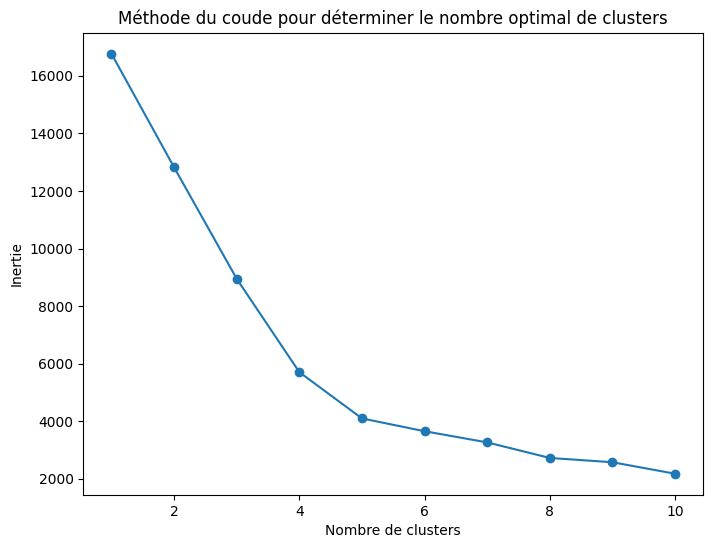

In [95]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clean_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

D'après le graph obtenu, le nombre optimisé de clusters semble être 4 ou 5.

In [96]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

df_scaled = clean_data.copy()

# Appliquer KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

# Convertir df_scaled en DataFrame pour inclure les clusters
df_scaled = pd.DataFrame(df_scaled, columns=clean_data.columns)
df_scaled['Cluster'] = clusters

# Affichage des résultats
print(df_scaled.describe(include='all'))

       DernierAchat   NbCommandes  MontantTotal     Pays_Code      Cluster
count  4.192000e+03  4.192000e+03  4.192000e+03  4.192000e+03  4192.000000
mean   1.349641e-14  1.864497e-17 -2.372996e-17  3.796793e-16     0.855916
std    1.000119e+00  1.000119e+00  1.000119e+00  1.000119e+00     1.301118
min   -2.814784e+00 -3.917271e-01 -4.662590e-01 -5.348925e+00     0.000000
25%   -5.103207e-01 -3.268553e-01 -3.725561e-01  2.938294e-01     0.000000
50%    4.195948e-01 -2.170723e-01 -2.545182e-01  2.938294e-01     0.000000
75%    7.492339e-01  3.742485e-02  4.607254e-02  2.938294e-01     2.000000
max    9.207364e-01  3.557720e+01  3.816637e+01  4.550509e-01     3.000000


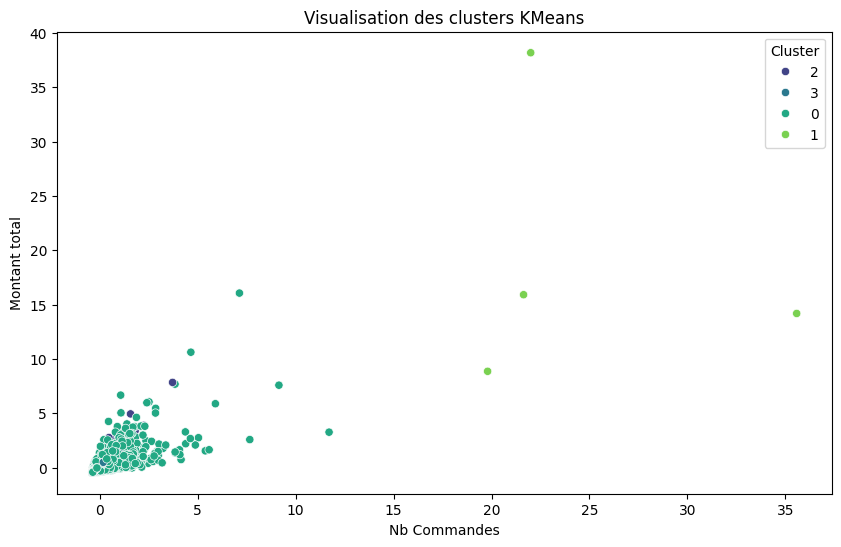

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns


df_scaled['Cluster'] = df_scaled['Cluster'].astype(str)

# Créer un graphique de dispersion avec les 2 premières dimensions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_scaled['NbCommandes'], y=df_scaled['MontantTotal'], hue=df_scaled['Cluster'], palette='viridis')
plt.title('Visualisation des clusters KMeans')
plt.xlabel('Nb Commandes')
plt.ylabel('Montant total')
plt.legend(title='Cluster', loc='upper right')
plt.show()


In [98]:
# Afficher des statistiques descriptives pour chaque cluster
cluster_analysis = df_scaled.groupby('Cluster').agg({
    'DernierAchat': ['mean', 'std', 'min', 'max'],
    'MontantTotal': ['mean', 'std', 'min', 'max'],
    'NbCommandes': ['mean', 'std', 'min', 'max']
})
print(cluster_analysis)

        DernierAchat                               MontantTotal             \
                mean       std       min       max         mean        std   
Cluster                                                                      
0           0.521326  0.344189 -0.771047  0.920729     0.071261   0.790598   
1           0.906376  0.016494  0.882547  0.920528    19.280043  12.943096   
2          -0.027001  1.056271 -2.801199  0.920736     0.162149   0.899962   
3          -1.507916  0.680410 -2.814784 -0.409201    -0.331918   0.152347   

                             NbCommandes                                  
              min        max        mean       std        min        max  
Cluster                                                                   
0       -0.465395  16.057621    0.064425  0.697408  -0.391727  11.704371  
1        8.862154  38.166367   24.752338  7.280554  19.798377  35.577197  
2       -0.466259   7.842128   -0.031067  0.478182  -0.391727   3.715158  
3  

In [99]:
df_scaled.drop('Cluster', axis=1, inplace=True)

In [100]:
from sklearn.metrics import silhouette_score


import numpy as np
from sklearn.metrics.pairwise import pairwise_distances



from sklearn.metrics import pairwise_distances_argmin_min

def calculate_inertia(X, labels):
    inertia = 0
    for i in np.unique(labels):
        cluster_points = X[labels == i]
        cluster_center = cluster_points.mean(axis=0)
        inertia += np.sum((cluster_points - cluster_center) ** 2)
    return inertia

inertia = calculate_inertia(df_scaled, clusters)
print(f"Inertia: {inertia}")



from sklearn.metrics import calinski_harabasz_score

calinski_harabasz = calinski_harabasz_score(df_scaled, clusters)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")


from sklearn.metrics import davies_bouldin_score

davies_bouldin = davies_bouldin_score(df_scaled, clusters)
print(f"Davies-Bouldin Index: {davies_bouldin}")


from sklearn.metrics import adjusted_mutual_info_score

Inertia: DernierAchat    1132.429094
NbCommandes     1652.461270
MontantTotal    2572.713585
Pays_Code        347.844356
dtype: float64
Calinski-Harabasz Index: 2706.767521874423
Davies-Bouldin Index: 0.5838352400135949


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [101]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir df_scaled en DataFrame si nécessaire
if not isinstance(df_scaled, pd.DataFrame):
    df_scaled = pd.DataFrame(df_scaled, columns=[f'Feature_{i}' for i in range(df_scaled.shape[1])])

# Supprimer la colonne Cluster si elle existe (évite les conflits)
df_scaled = df_scaled.drop(['Cluster'], axis=1, errors='ignore')

# Appliquer Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
clusters = agg_clustering.fit_predict(clean_data)

# Ajouter les clusters à l'échantillon
clean_data['Cluster'] = clusters

# Vérifier les colonnes avant la visualisation
print("Colonnes disponibles dans clean_data :", clean_data.columns)

Colonnes disponibles dans clean_data : Index(['DernierAchat', 'NbCommandes', 'MontantTotal', 'Pays_Code', 'Cluster'], dtype='object')


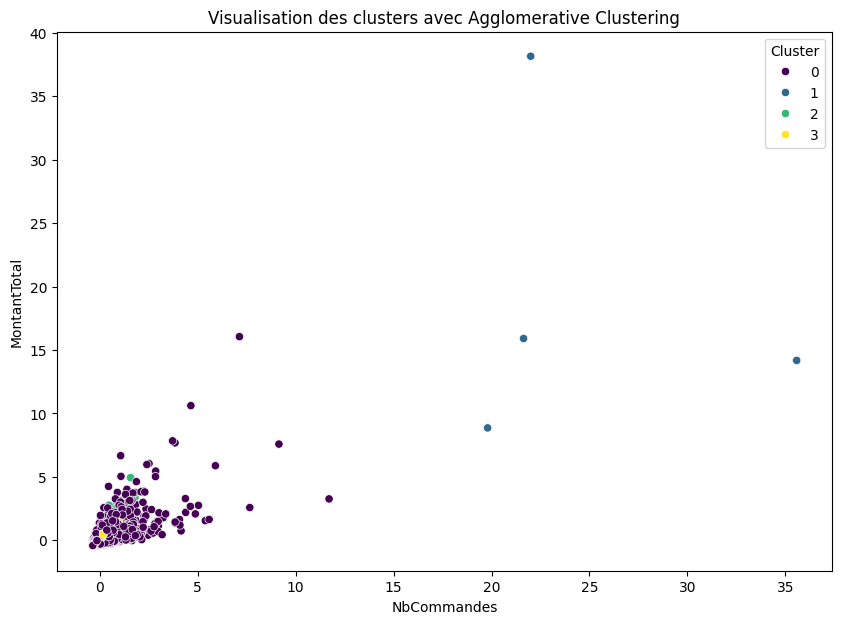

In [102]:
# Visualisation des clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=clean_data.iloc[:, 1],  # Première colonne
    y=clean_data.iloc[:, 2],  # Deuxième colonne
    hue='Cluster',
    palette='viridis',
    data=clean_data
)
plt.title("Visualisation des clusters avec Agglomerative Clustering")
plt.show()

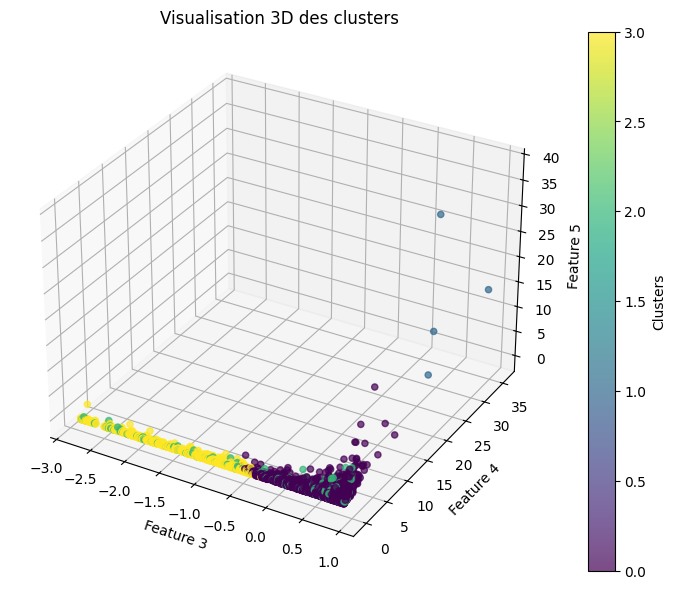

In [103]:
from mpl_toolkits.mplot3d import Axes3D

# Préparer une figure pour le graphique 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Sélectionner trois colonnes pour l'affichage
x = clean_data.iloc[:, 0]  # Colonne pour l'axe X
y = clean_data.iloc[:, 1]  # Colonne pour l'axe Y
z = clean_data.iloc[:, 2]  # Colonne pour l'axe Z

# Ajouter les points avec les couleurs des clusters
scatter = ax.scatter(
    x, y, z,
    c=clean_data['Cluster'],  # Couleurs en fonction des clusters
    cmap='viridis',          # Palette de couleurs
    s=20,                    # Taille des points
    alpha=0.7                # Transparence
)

# Ajouter des légendes et des étiquettes
ax.set_title("Visualisation 3D des clusters")
ax.set_xlabel("Feature 3")
ax.set_ylabel("Feature 4")
ax.set_zlabel("Feature 5")
fig.colorbar(scatter, ax=ax, label="Clusters")

plt.show()

In [104]:
import plotly.express as px
import pandas as pd

# Créer un DataFrame pour Plotly avec les colonnes nécessaires
df_plotly = clean_data.copy()

# Assurez-vous que les colonnes utilisées sont bien présentes et choisies
# Exemple : Feature 4, Feature 5, Feature 6
fig = px.scatter_3d(
    df_plotly,
    x=df_plotly.iloc[:, 1],   # Axe X
    y=df_plotly.iloc[:, 2],   # Axe Y
    z=df_plotly.iloc[:, 3],   # Axe Z
    color=df_plotly['Cluster'],  # Cluster pour la couleur
    labels={'color': 'Clusters'},  # Label pour la légende
    title="Visualisation interactive des clusters en 3D",
    opacity=0.7               # Transparence des points
)

# Ajuster l'apparence du graphique
fig.update_traces(marker=dict(size=5))  # Taille des points
fig.update_layout(scene=dict(
    xaxis_title="Feature 4",
    yaxis_title="Feature 5",
    zaxis_title="Feature 6"
))

# Afficher le graphique
fig.show()

## Analyse en Composantes Principales (ACP)

L'ACP est une méthode statistique de réduction de dimension qui permet de transformer un ensemble de variables corrélées en un nombre plus restreint de variables décorrélées, appelées composantes principales. Cette méthode est utilisée pour résumer l’information contenue dans un jeu de données et pour identifier les structures sous-jacentes dans les données.

**Principe**
L’ACP consiste à diagonaliser la matrice de corrélation des variables, ce qui permet de trouver les axes principaux qui expliquent la variabilité des données. Les composantes principales sont des combinaisons linéaires des variables originales qui maximisent la variance expliquée. Les axes principaux sont ordonnés en fonction de l’inertie qu’ils expliquent, c’est-à-dire de la variance qu’ils capturent.

**Avantages**
* Réduction de dimension : L’ACP permet de réduire le nombre de variables à analyser, ce qui facilite l’interprétation des résultats et réduit les coûts de traitement des données.
* Décorrélation : Les composantes principales sont décorrélées entre elles, ce qui facilite l’analyse et l’interprétation des résultats.
* Identification de structures sous-jacentes : L’ACP permet d’identifier les structures sous-jacentes dans les données, telles que les facteurs de variation, les groupes de variables corrélées, etc.

**Applications**
* Analyse de données multi-variées : L’ACP est utilisée pour analyser des jeux de données composés de plusieurs variables quantitatives et/ou qualitatives.
Réduction de données : L’ACP est utilisée pour réduire le nombre de variables dans un jeu de données avant d’appliquer d’autres méthodes d’analyse statistique.
* Analyse de données spatiales : L’ACP est utilisée pour analyser des données spatiales, telles que les données géographiques ou les images, en identifiant les structures sous-jacentes et les corrélations entre les variables.

**Limites**
* Assumptions : L’ACP suppose que les données sont normalement distribuées et que les corrélations entre les variables sont linéaires.
* Interprétation : L’interprétation des résultats de l’ACP nécessite une bonne compréhension des concepts statistiques et des propriétés des composantes principales.


En résumé, l’Analyse en Composantes Principales (ACP) est une méthode statistique puissante pour réduire la dimension de données multi-variées, identifier les structures sous-jacentes et décorréler les variables. Cependant, elle nécessite des assumptions spécifiques et une bonne interprétation des résultats.

Variance expliquée par chaque composante :
[0.47187716 0.25306894 0.22038548 0.05466842]
Variance cumulée :
[0.47187716 0.7249461  0.94533158 1.        ]


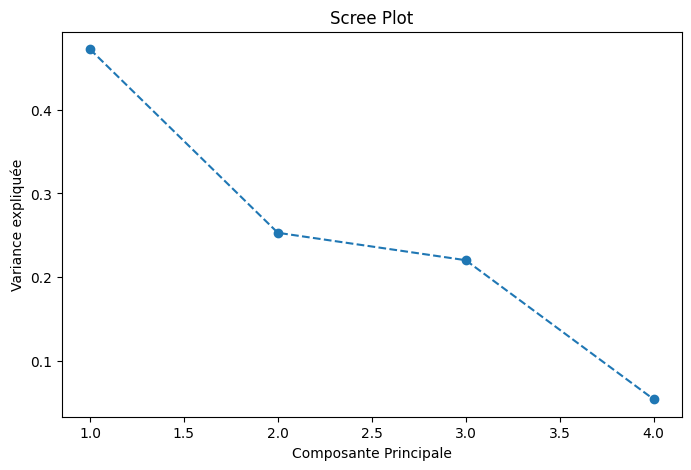

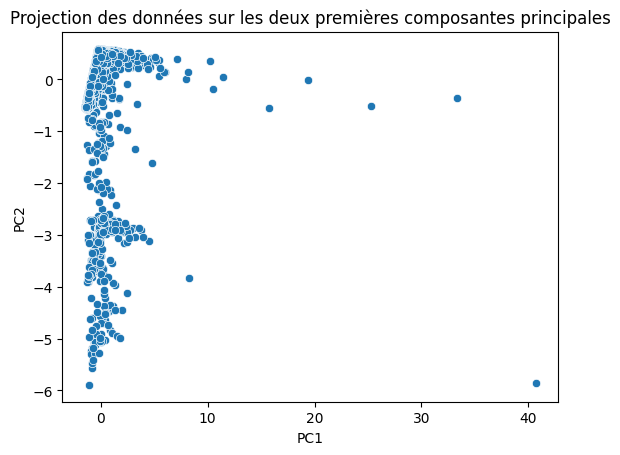

Contribution des variables aux composantes principales :
                   PC1       PC2       PC3       PC4
DernierAchat  0.326077  0.306767  0.893505 -0.034864
NbCommandes   0.662780  0.001862 -0.269772 -0.698528
MontantTotal  0.671590 -0.068820 -0.193688  0.711840
Pays_Code    -0.057986  0.949291 -0.302252  0.064242


In [105]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Étape 2 : Appliquer l'ACP
pca = PCA()
pca_result = pca.fit_transform(df_scaled)

# Étape 3 : Analyse des résultats
# Variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_
print("Variance expliquée par chaque composante :")
print(explained_variance)

# Variance cumulée
cumulative_variance = np.cumsum(explained_variance)
print("Variance cumulée :")
print(cumulative_variance)

# Étape 4 : Visualisation
# Scree plot (éboulis des valeurs propres)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Composante Principale')
plt.ylabel('Variance expliquée')
plt.show()

# Visualisation des composantes principales
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('Projection des données sur les deux premières composantes principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Étape 5 : Contribution des variables aux composantes principales
# Use df_scaled.columns as index since PCA was performed on df_scaled
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
                        index=df_scaled.columns)  # Changed to df_scaled.columns
print("Contribution des variables aux composantes principales :")
print(loadings)

## Analyse des Correspondances multiples (ACM)

L’ACM est une méthode statistique qui permet d’étudier l’association entre plusieurs variables catégorielles pour une population d’individus statistiques. Elle est une généralisation de l’Analyse Factorielle des Correspondances (AFC), qui s’applique à deux variables qualitatives, et permet de représenter les modalités de réponse de plusieurs variables qualitatives sur un même mapping.

**Principe**
L’ACM consiste à construire un tableau disjonctif complet (=tableau de Burt) qui présente les individus en lignes et les modalités des variables qualitatives en colonnes. Les cases d’intersection contiennent la valeur 1 si l’individu répond au critère en colonne et 0 sinon. Cette matrice est ensuite soumise à une analyse factorielle, qui permet de dégager des dimensions cachées (ou axes) qui capturent les relations entre les modalités des variables.

En résumé, l’Analyse des Correspondances Multiples (ACM) est une méthode statistique qui permet d’étudier l’association entre plusieurs variables qualitatives et de représenter les individus sur un même mapping en fonction de leurs caractéristiques.

In [112]:
import prince  # Bibliothèque pour réaliser des ACM

# Appliquer l'ACM
mca = prince.MCA(
    n_components=2,  # Nombre de dimensions à conserver
    n_iter=100,      # Nombre d'itérations
    copy=True,
    check_input=True,
    engine='sklearn',  # Changed engine to a valid option
    random_state=42
)

# Ajuster le modèle sur les données
mca = mca.fit(df_scaled)

# Résultats de l'ACM
# Coordonnées des lignes
row_coords = mca.row_coordinates(df_scaled)
print("Coordonnées des lignes :")
print(row_coords.head())

# Coordonnées des colonnes (modalités)
column_coords = mca.column_coordinates(df_scaled)
print("Coordonnées des modalités :")
print(column_coords.head())

# Inertie totale
total_inertia_ = mca.total_inertia_
print("Inertie totale pour chaque composante :")
print(total_inertia_)

Coordonnées des lignes :
            0         1
0.0 -0.035610 -0.378568
1.0 -0.034862 -0.178925
2.0 -0.035668  0.584202
3.0 -0.036384  1.413602
4.0 -0.036648  0.367408
Coordonnées des modalités :
                                          0         1
DernierAchat__-2.8147839969058084 -0.029468 -0.071307
DernierAchat__-2.8140053246124013 -0.029846 -0.073072
DernierAchat__-2.813880180850961  -0.029777 -0.058091
DernierAchat__-2.813741132227138  -0.029415 -0.063048
DernierAchat__-2.8136020836033153 -0.029399 -0.065478
Inertie expliquée par chaque composante :
2147.5000000000578


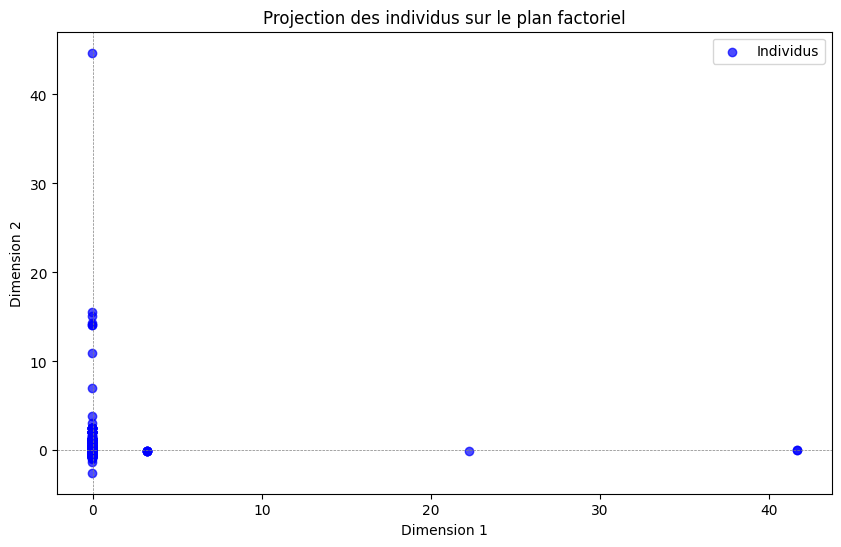

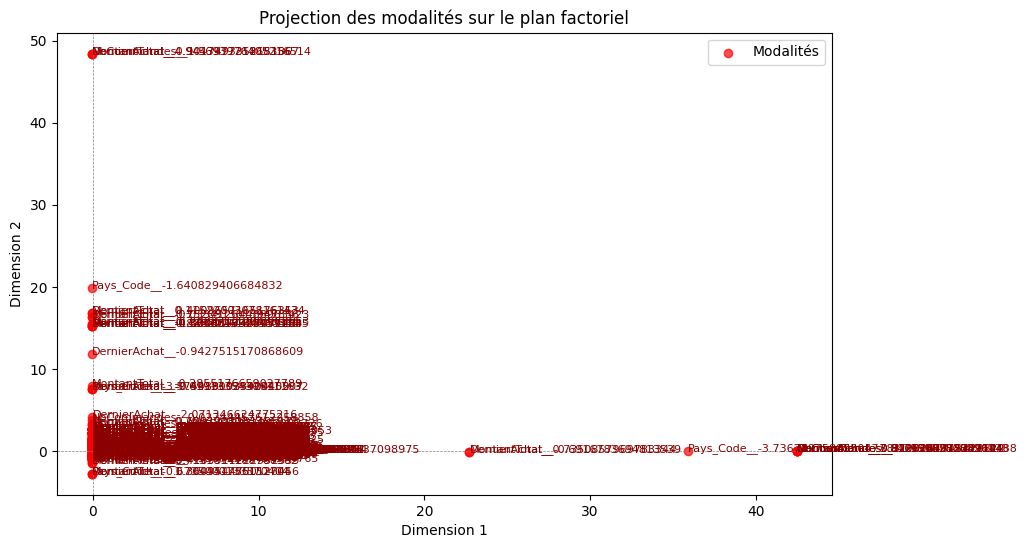

In [113]:
import matplotlib.pyplot as plt

# Coordonnées des lignes (individus)
row_coords = mca.row_coordinates(clean_data)
# Coordonnées des modalités (catégories)
column_coords = mca.column_coordinates(clean_data)

# Graphique 1 : Projection des individus
plt.figure(figsize=(10, 6))
plt.scatter(row_coords[0], row_coords[1], alpha=0.7, color='blue', label='Individus')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.title("Projection des individus sur le plan factoriel")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

# Graphique 2 : Projection des modalités
plt.figure(figsize=(10, 6))
plt.scatter(column_coords[0], column_coords[1], alpha=0.7, color='red', label='Modalités')
for i, txt in enumerate(column_coords.index):
    plt.annotate(txt, (column_coords.iloc[i, 0], column_coords.iloc[i, 1]), fontsize=8, color='darkred')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.title("Projection des modalités sur le plan factoriel")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()
